<a href="https://colab.research.google.com/github/AnushkaMazumdar2/Re-inforcement-Learning/blob/main/2348505_Lab10(RL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Necessary Libraries**

In [2]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

### **Policy Network:**

A simple feedforward neural network defines the policy and outputs probabilities for each action.

- A neural network to model the policy.
- Two fully connected layers (fc1 and fc2) with a ReLU activation and a softmax output layer.

In [3]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### **Action Selection:**

Given the state, the network predicts probabilities. Actions are sampled from the resulting distribution.

- Converts the state to a tensor.
- Computes action probabilities using the policy network.
- Samples an action from the probability distribution and returns it along with its log-probability.

In [4]:
def select_action(policy_net, state):
    state = torch.tensor(state, dtype=torch.float32)
    action_probs = policy_net(state)
    action_dist = torch.distributions.Categorical(action_probs)
    action = action_dist.sample()
    return action.item(), action_dist.log_prob(action)

### **Environment Rendering**

Runs a single episode and captures frames as the agent interacts with the environment.

In [5]:
def render_episode(env, policy_net):
    state = env.reset()
    frames = []
    done = False
    while not done:
        frames.append(env.render(mode="rgb_array"))
        action, _ = select_action(policy_net, state)
        state, _, done, _ = env.step(action)
    env.close()
    return frames

**Animation Creation**

Creates an animation from the frames collected during an episode.

In [6]:
def create_animation(frames):
    fig, ax = plt.subplots()
    ax.axis('off')
    img = ax.imshow(frames[0])

    def update(frame):
        img.set_data(frame)
        return [img]

    ani = FuncAnimation(fig, update, frames=frames, interval=50, blit=True)
    plt.close(fig)
    return ani

### **REINFORCE Algorithm**

- **Initialization and Training Loop**

 - Initializes the environment and neural network.
 - Sets up the optimizer and prepares to track rewards.

- **Generate Episodes and Collect Data**

  - Runs an episode, collecting log-probabilities of actions and rewards.

- **Compute Discounted Rewards**
 - Computes the discounted rewards and normalizes them to stabilize training

- **Compute Policy Gradient and Update Policy**
 - Calculates the policy gradient loss.
 - Updates the policy network using backpropagation.

- **Logging and Visualization**
  - Logs the reward per episode and plots cumulative rewards.

In [7]:
def reinforce(env_name, hidden_dim=128, lr=0.01, gamma=0.99, episodes=1000):
    env = gym.make(env_name)
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    policy_net = PolicyNetwork(input_dim, hidden_dim, output_dim)
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)

    episode_rewards = []

    for episode in range(episodes):
        state = env.reset()
        log_probs = []
        rewards = []

        # Generate an episode
        while True:
            action, log_prob = select_action(policy_net, state)
            next_state, reward, done, _ = env.step(action)

            log_probs.append(log_prob)
            rewards.append(reward)

            if done:
                break

            state = next_state

        # Compute discounted rewards
        discounted_rewards = []
        cumulative_reward = 0
        for reward in reversed(rewards):
            cumulative_reward = reward + gamma * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)

        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-8)  # Normalize

        # Compute policy gradient loss
        policy_gradient = []
        for log_prob, reward in zip(log_probs, discounted_rewards):
            policy_gradient.append(-log_prob * reward)

        loss = torch.stack(policy_gradient).sum()

        # Update policy network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Logging
        episode_reward = sum(rewards)
        episode_rewards.append(episode_reward)
        print(f"Episode {episode + 1}: Total Reward: {episode_reward}")

    # Plotting the rewards
    plt.figure()
    plt.plot(episode_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Policy Gradient Performance")
    plt.show()

    # Simulate and render an episode
    frames = render_episode(env, policy_net)
    ani = create_animation(frames)
    display(HTML(ani.to_jshtml()))

    env.close()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1: Total Reward: 17.0
Episode 2: Total Reward: 28.0
Episode 3: Total Reward: 31.0
Episode 4: Total Reward: 20.0
Episode 5: Total Reward: 29.0
Episode 6: Total Reward: 12.0
Episode 7: Total Reward: 10.0
Episode 8: Total Reward: 13.0
Episode 9: Total Reward: 10.0
Episode 10: Total Reward: 9.0
Episode 11: Total Reward: 18.0
Episode 12: Total Reward: 10.0
Episode 13: Total Reward: 9.0
Episode 14: Total Reward: 10.0
Episode 15: Total Reward: 18.0
Episode 16: Total Reward: 8.0
Episode 17: Total Reward: 10.0
Episode 18: Total Reward: 13.0
Episode 19: Total Reward: 9.0
Episode 20: Total Reward: 12.0
Episode 21: Total Reward: 10.0
Episode 22: Total Reward: 13.0
Episode 23: Total Reward: 10.0
Episode 24: Total Reward: 10.0
Episode 25: Total Reward: 13.0
Episode 26: Total Reward: 10.0
Episode 27: Total Reward: 9.0
Episode 28: Total Reward: 13.0
Episode 29: Total Reward: 12.0
Episode 30: Total Reward: 9.0
Episode 31: Total Reward: 10.0
Episode 32: Total Reward: 8.0
Episode 33: Total Reward

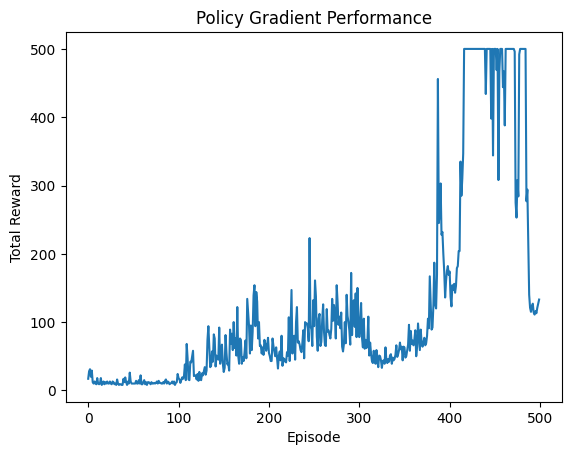

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning

In [8]:
if __name__ == "__main__":
    reinforce(env_name="CartPole-v1", hidden_dim=128, lr=0.01, gamma=0.99, episodes=500)

### **Inference**

This implementation of the policy gradient algorithm demonstrates the REINFORCE method in a simulated environment, using a neural network to approximate the policy. The approach trains the agent through episodic interactions, learning to optimize its actions based on rewards. By computing and normalizing discounted rewards, the agent adjusts its policy network parameters via backpropagation to maximize long-term rewards. The framework also visualizes training performance through reward plots and simulates agent behavior with an animation of the environment. This dynamic feedback loop highlights the effectiveness of policy gradient methods in reinforcement learning for tasks like balancing the CartPole.

---